# Drawing flight paths on maps with cartopy (bonus: on Google Maps tiles)

We spent a lot of time tracking down suspicious planes, don't we want to dress it all up with some visualizations of where they're flying?

<p class="reading-options">
  <a class="btn" href="/buzzfeed-spy-planes/drawing-flight-paths-on-maps-with-cartopy">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/buzzfeed-spy-planes/notebooks/Drawing flight paths on maps with cartopy.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **flights_data4-1529539200-cleaned.csv:** raw flight data - a selection of raw data from from opensky
* **opensky-features.csv:** plane feature data - individual plane readings converted into descriptive features about how individual planes fly


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/flights_data4-1529539200-cleaned.csv.zip -P data
!unzip -n -d data data/flights_data4-1529539200-cleaned.csv.zip
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/opensky-features.csv -P data

# Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
%matplotlib inline

# Read in our data

We're doing to be using **two datasets** for this.

First, we'll need our plane features - how hight they were flying, how fast they were flying, how much they were steering, etc etc. We'll use this to find the codes for interesting planes.

Second, we'll need all of the original flight readings. We'll take their readings for the planes we're interested in and draw lines between them, essentially recreating the flight paths.

In [2]:
# Feature data
features = pd.read_csv("data/opensky-features.csv")
features.head(2)

,icao24,altitude1,altitude2,altitude3,altitude4,altitude5,duration1,duration2,duration3,duration4,duration5,area1,area2,area3,area4,area5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,observations
0,000001,70.951157,28.149100,0.899743,0.000000,0.000000,33.333333,0.0,0.0,0.0,66.666667,100.0,0.0,0.0,0.0,0.0,1.609788,2.318094,56.213780,6.696716,3.090792,27.817128,1.094656,1.159047,1556
1,010154,2.357564,3.339882,8.447937,3.536346,82.318271,0.000000,0.0,0.0,0.0,100.000000,0.0,0.0,100.0,0.0,0.0,0.000000,0.196850,7.874016,75.590551,12.598425,3.543307,0.196850,0.000000,509


In [3]:
# Original data
df = pd.read_csv('data/flights_data4-1529539200-cleaned.csv', dtype={'icao24': 'str'})
df.head(2)

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
0,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574561,609.6,41.702100,-86.469939,88.232170
1,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574559,609.6,41.702042,-86.472140,88.253716


# Which planes are we interested in?

If a plane is steering to the left or right a lot, it's probably going in circles! Let's take the top 10 planes that have high `steer2` values as our **suspicious planes.**

In [4]:
suspicious = features.sort_values(by='steer2', ascending=False).head(10)
suspicious

,icao24,altitude1,altitude2,altitude3,altitude4,altitude5,duration1,duration2,duration3,duration4,duration5,area1,area2,area3,area4,area5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,observations
417,A0B27E,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,6.850716,27.607362,27.096115,8.486708,2.760736,24.948875,0.817996,1.431493,979
3439,AC9C6D,88.649284,11.350716,0.000000,0.000000,0.0,33.333333,0.000000,33.333333,0.000000,33.333333,100.000000,0.000000,0.0,0.0,0.0,6.139663,22.950177,52.961946,7.414672,0.961161,9.042762,0.117693,0.411926,5101
615,A18EBB,0.000000,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,0.000000,0.0,0.0,0.0,11.894273,21.035242,28.414097,29.845815,0.440529,0.991189,0.770925,6.607930,909
838,A26A04,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,5.488851,19.897084,47.341338,19.554031,1.543739,6.174957,0.000000,0.000000,584
3834,AE4E15,0.000000,5.326877,94.673123,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,0.000000,0.0,0.0,0.0,9.939394,19.393939,35.272727,5.696970,1.333333,22.060606,2.424242,3.878788,826
3833,AE4CFE,5.675147,12.524462,78.864971,2.935421,0.0,85.714286,14.285714,0.000000,0.000000,0.000000,85.714286,14.285714,0.0,0.0,0.0,7.539683,17.063492,51.984127,8.730159,2.976190,10.119048,0.000000,1.587302,511
1695,A662B8,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,33.333333,66.666667,0.000000,100.000000,0.000000,0.0,0.0,0.0,0.818898,16.188976,55.653543,3.826772,0.787402,22.614173,0.047244,0.062992,6353
56,268883,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,100.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,10.739437,15.140845,20.774648,19.190141,2.288732,25.000000,3.697183,3.169014,569
740,A1EA3D,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,50.000000,50.000000,0.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,6.562500,14.843750,47.187500,14.531250,3.906250,12.656250,0.000000,0.312500,642
2278,A8F8C3,0.291971,1.532847,98.175182,0.000000,0.0,0.000000,33.333333,0.000000,66.666667,0.000000,0.000000,100.000000,0.0,0.0,0.0,5.632772,13.899049,34.528164,5.486467,2.121434,32.918800,3.511339,1.901975,1370


We'll then find the **readings of those interesting planes.**

> The features have a code in capitals - `A26A04` - while the readings have lowercase - `a26a04` - so we'll need to adjust for that.

In [5]:
readings = df[df.icao24.isin(suspicious.icao24.str.lower())]
readings.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
1060324,a26a04,N2549Y,1529539200,1.529611e+09,1529616871,KN14,KN14,1529616864,0.0,39.916868,-74.804993,317.121094
1060325,a26a04,N2549Y,1529539200,1.529611e+09,1529616871,KN14,KN14,1529616859,0.0,39.915756,-74.803878,317.121094
1060326,a26a04,N2549Y,1529539200,1.529611e+09,1529616871,KN14,KN14,1529616858,0.0,39.915619,-74.803759,311.552612
1060327,a26a04,N2549Y,1529539200,1.529611e+09,1529616871,KN14,KN14,1529616857,0.0,39.915425,-74.803467,310.292145
1060328,a26a04,N2549Y,1529539200,1.529611e+09,1529616871,KN14,KN14,1529616855,0.0,39.915053,-74.802795,304.992035


Then we can organize them into flights based on the `firstseen` column.

In [6]:
flights = readings.groupby(['firstseen', 'icao24'])
len(flights)

23

# Draw the flight paths

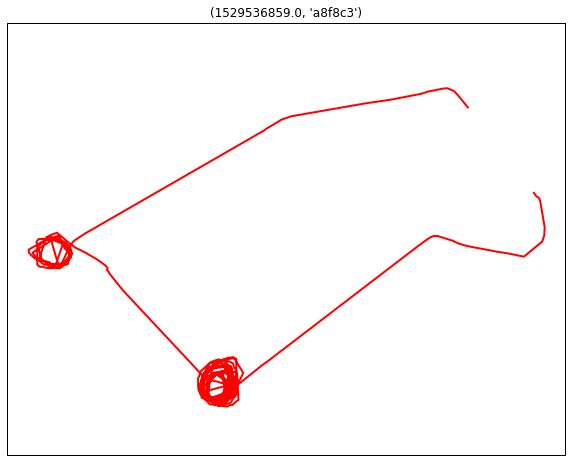

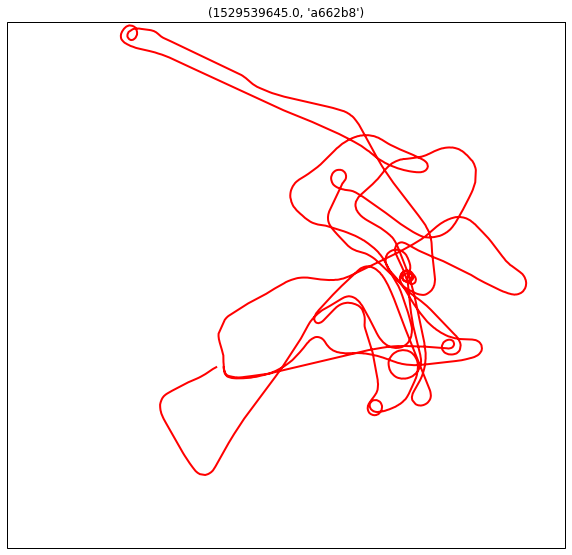

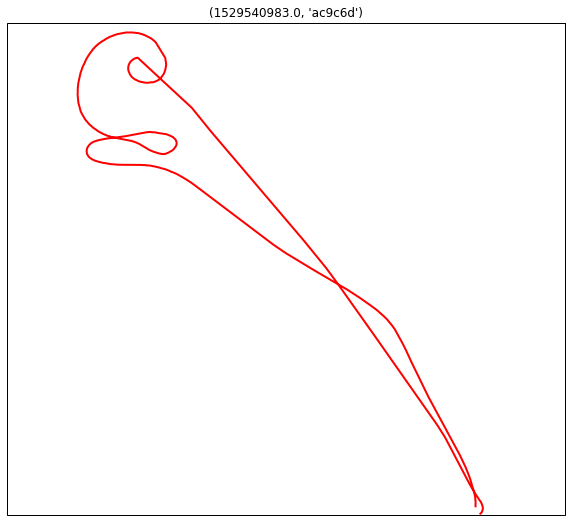

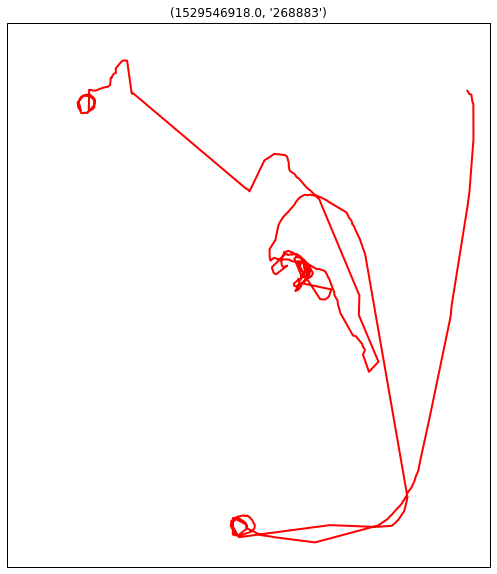

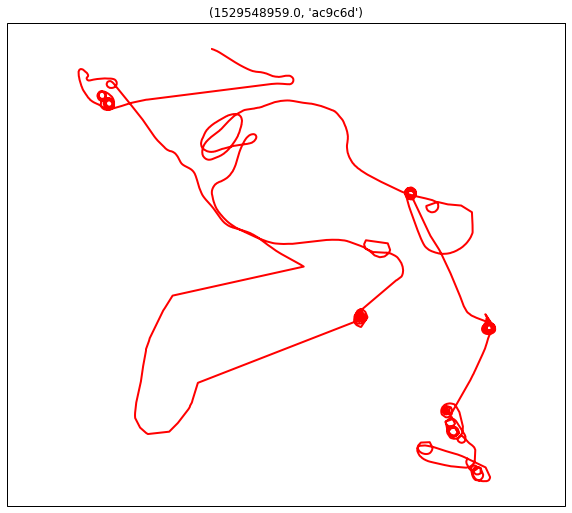

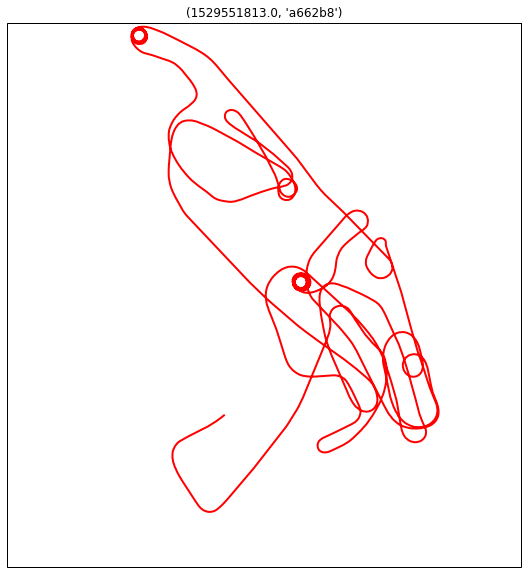

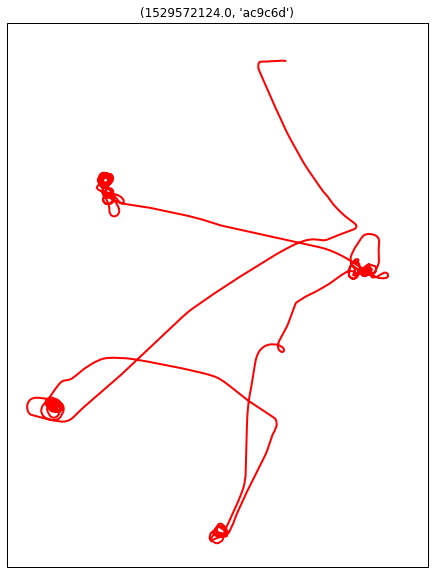

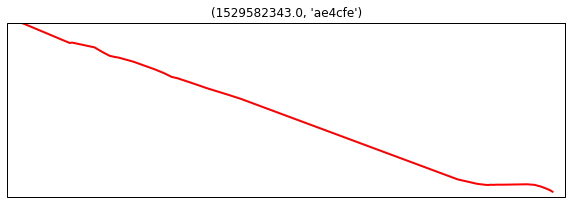

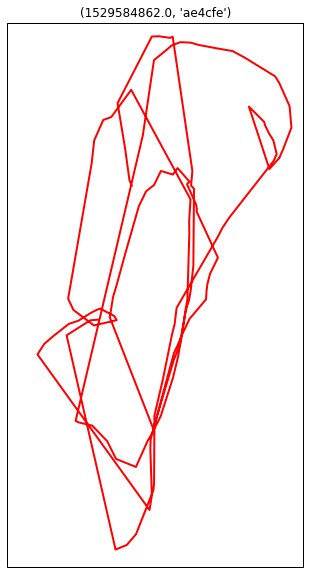

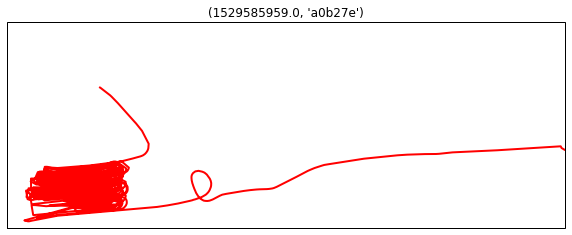

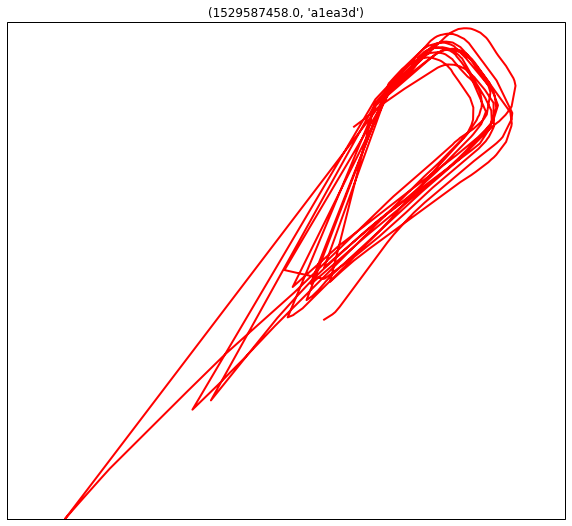

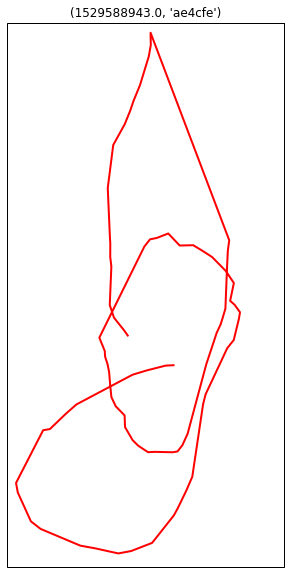

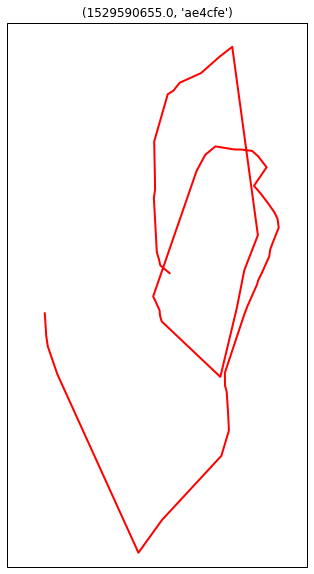

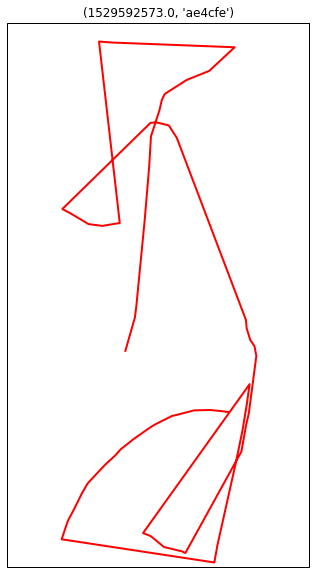

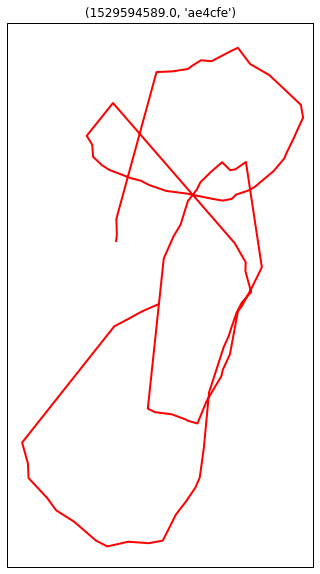

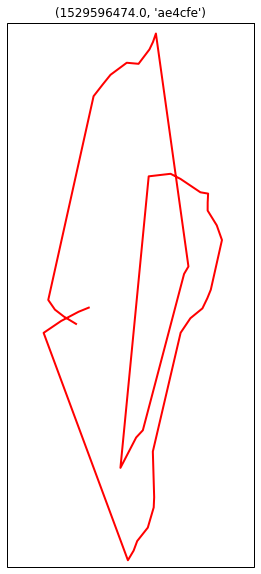

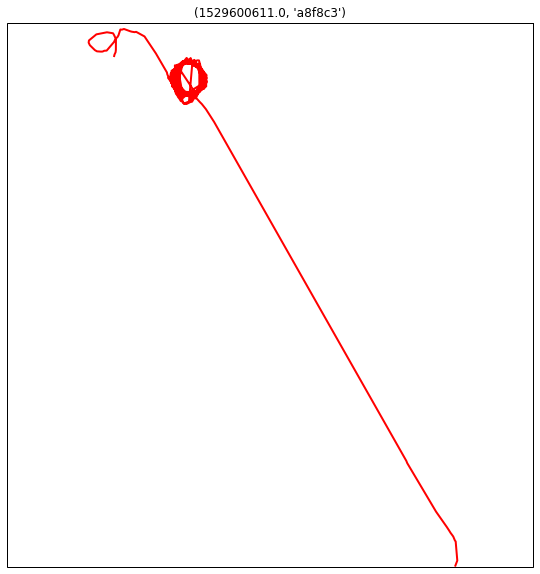

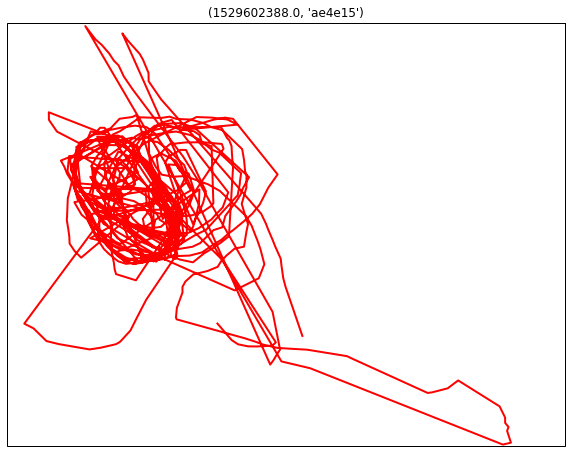

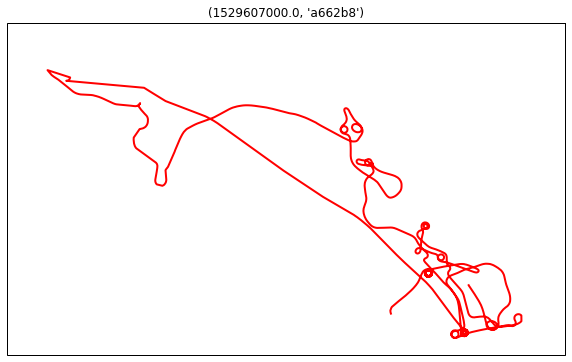

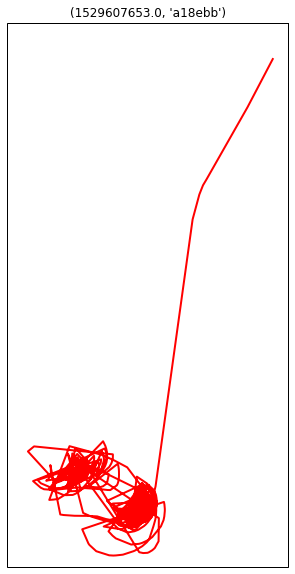

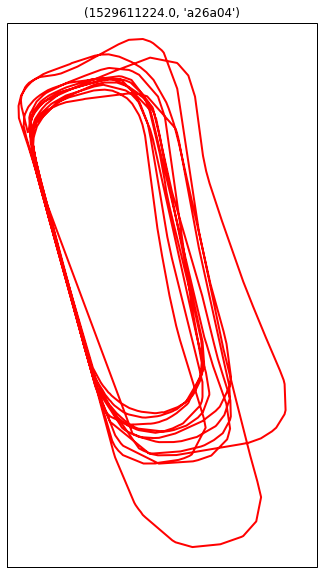

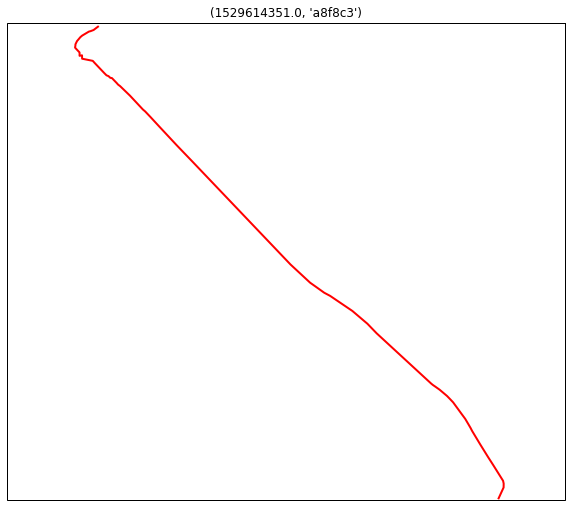

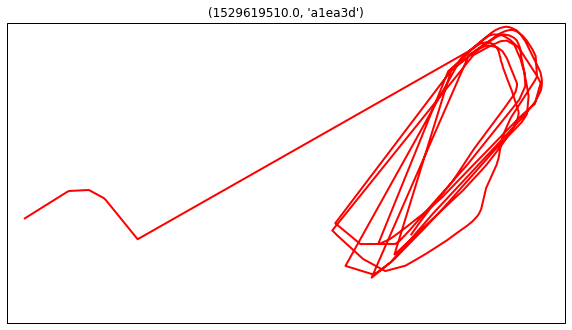

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

for name, flight in flights:
    # 
    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(projection=ccrs.LambertConformal())
    plt.title(name)

    # Set the boundaries around the map
    ax.set_extent([ 
        flight.longitude.max(), flight.longitude.min(),
        flight.latitude.min(), flight.latitude.max()
    ], crs=ccrs.Geodetic())

    # Draw the path of the fligt
    track = sgeom.LineString(zip(flight.longitude, flight.latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)

Those are some pretty exciting flight paths! But... where are they? We can do better if we **fill the background with Google Maps tiles.**

# Map tile backgrounds for cartopy

We hit a rate limit pretty quickly if we use them, though, so we need to jump through a couple hoops to make sure we cache them. The "couple hoops" means "run this code below."

In [8]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL

class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.__func__, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'

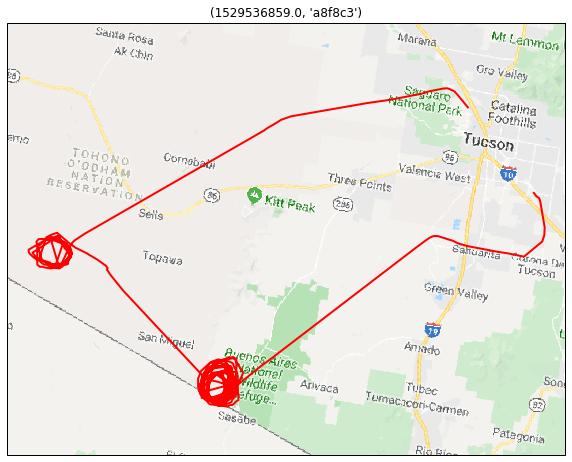

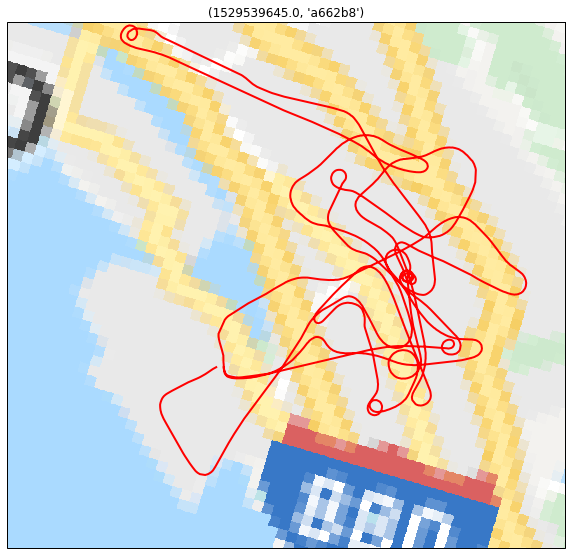

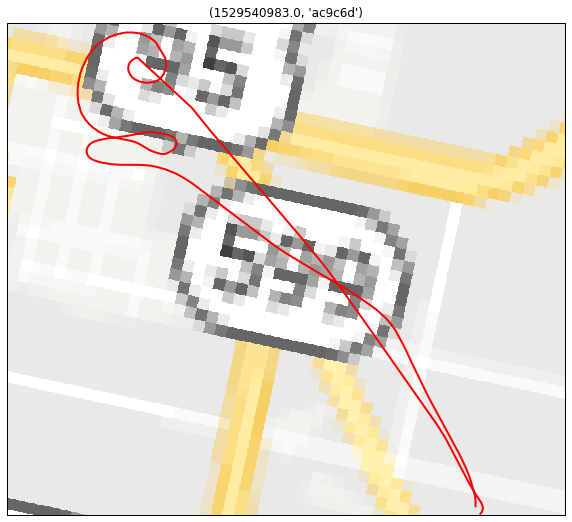

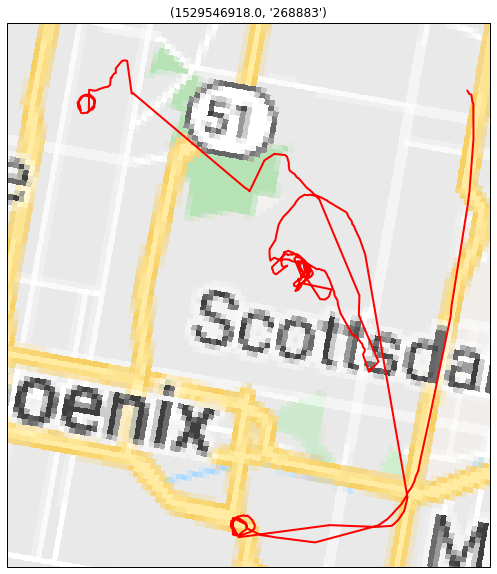

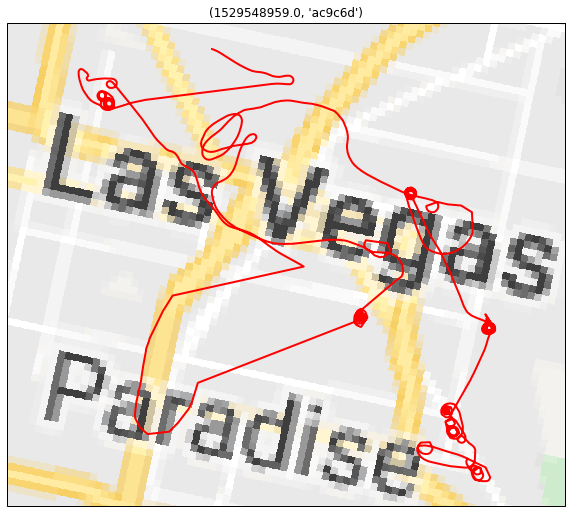

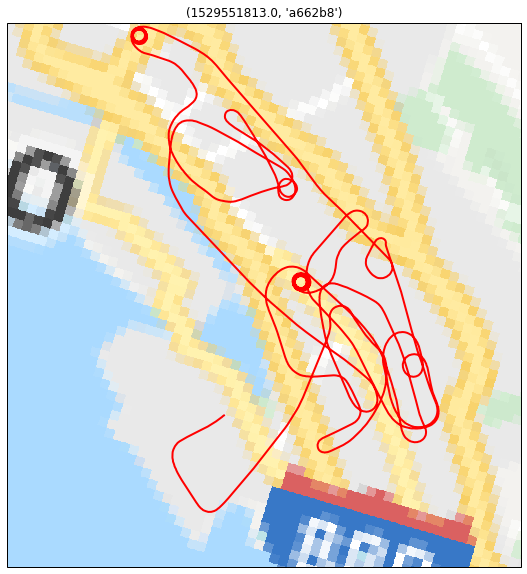

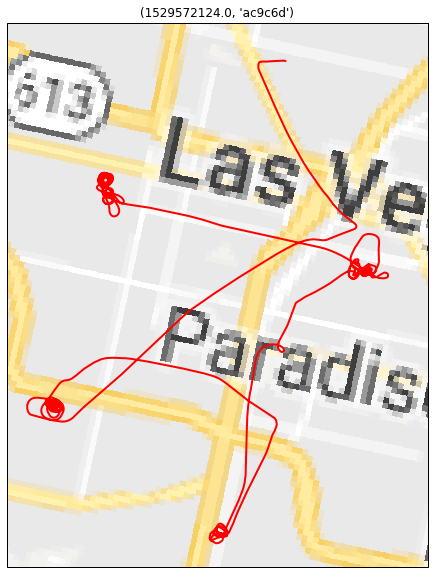

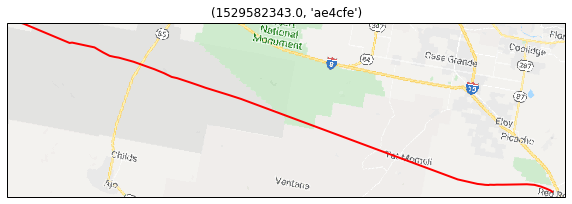

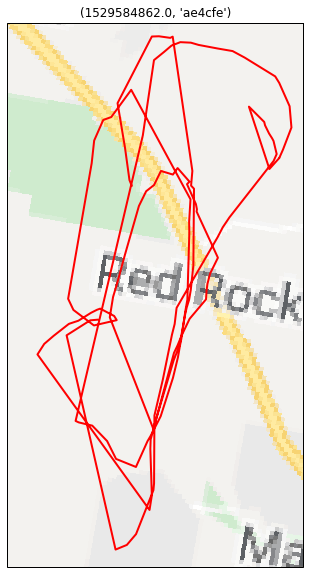

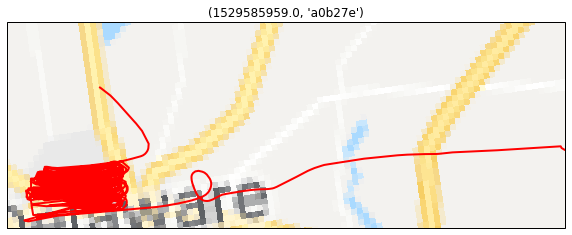

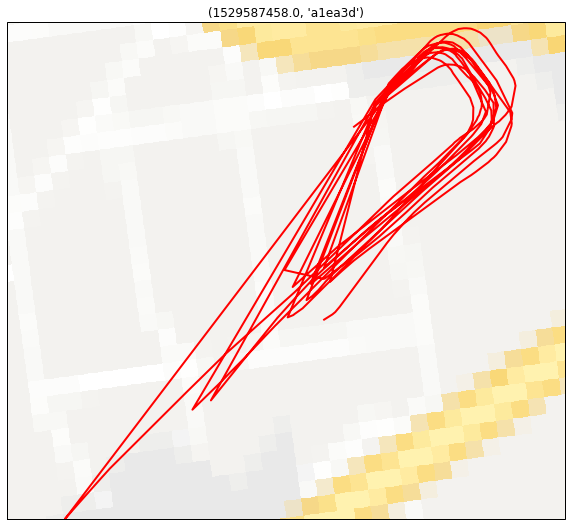

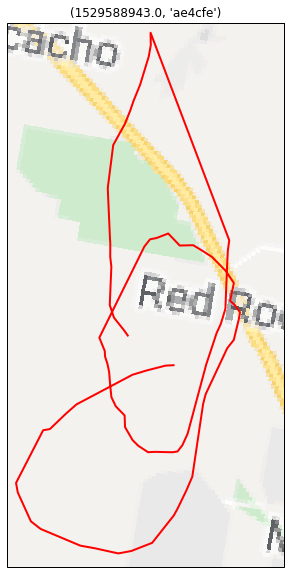

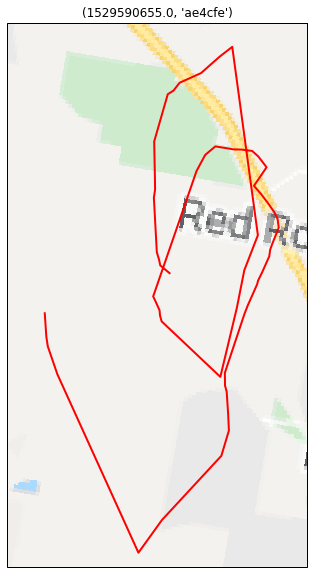

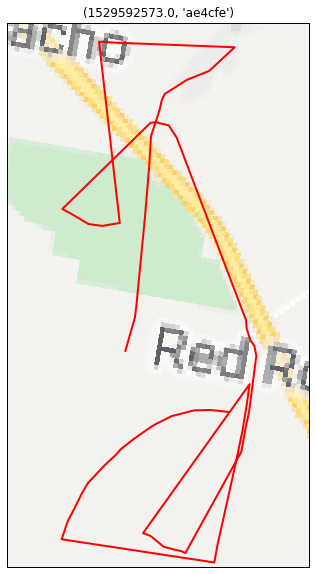

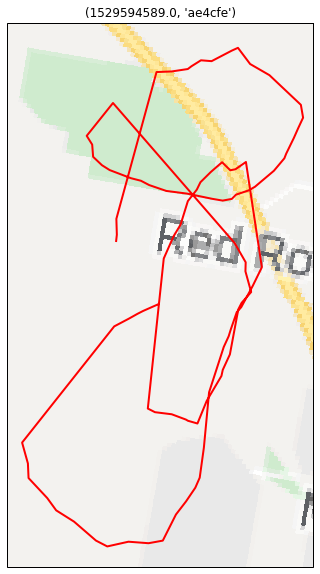

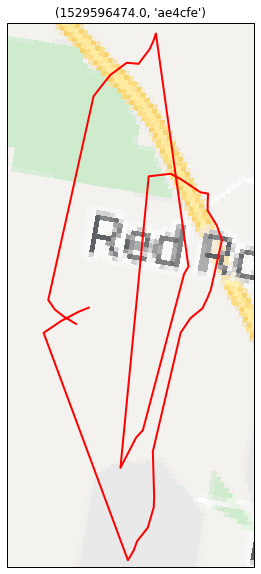

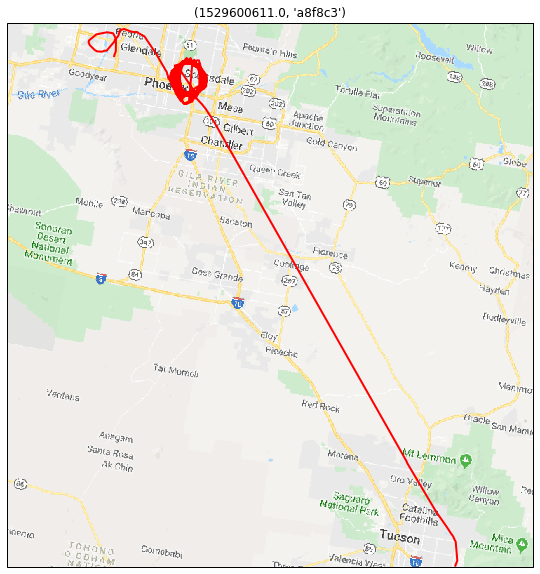

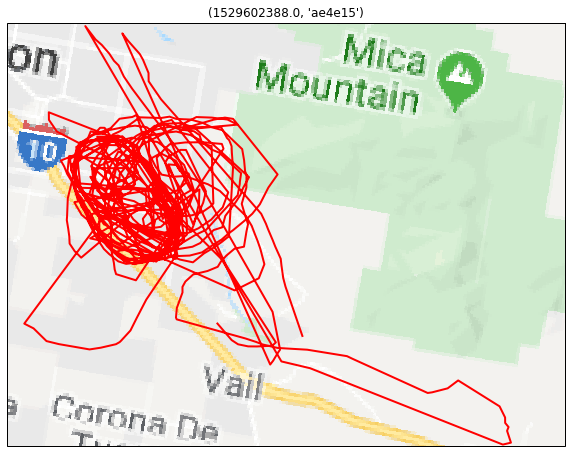

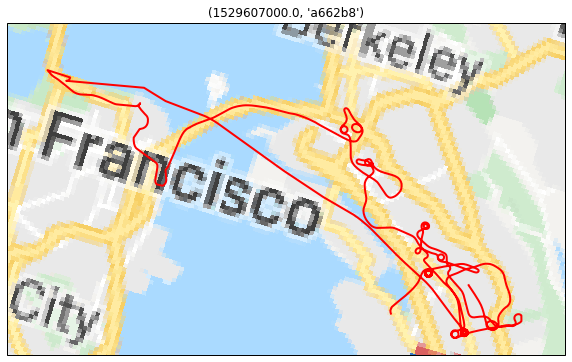

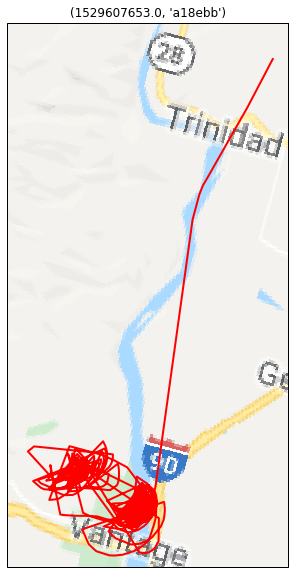

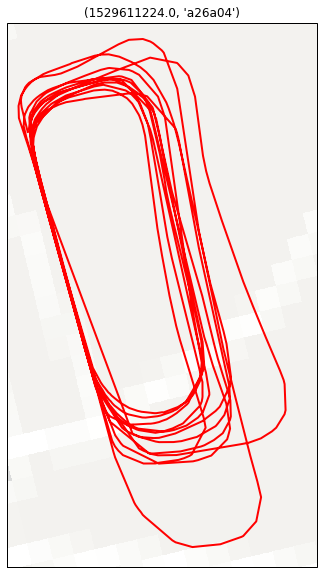

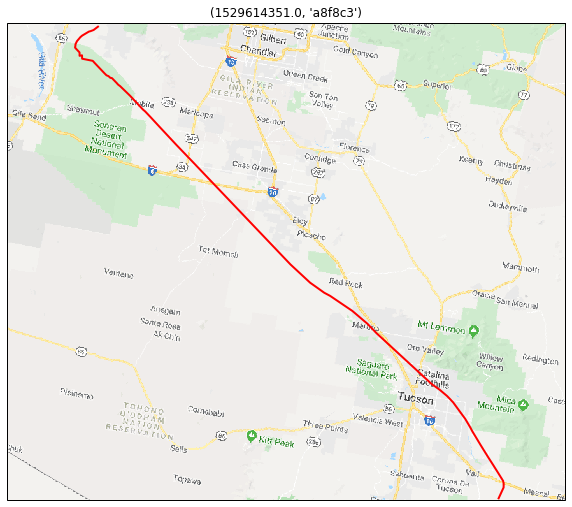

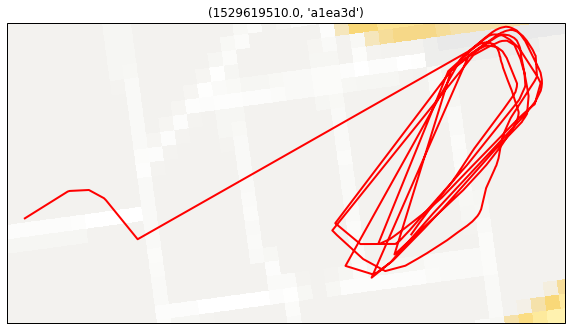

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt

# Initialize our Google Maps tiles
actual_tiler = cimgt.GoogleTiles()
imagery = CachedTiler(actual_tiler)

for name, flight in flights:
    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(projection=ccrs.LambertConformal())
    plt.title(name)

    # Set the boundaries around the map
    ax.set_extent([ 
        flight.longitude.max(), flight.longitude.min(),
        flight.latitude.min(), flight.latitude.max()
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)

    # Draw the path of the fligt
    track = sgeom.LineString(zip(flight.longitude, flight.latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)

# Let's put them all on one graphic

Just in case we wanna get crazy, let's put them all on one graphic.

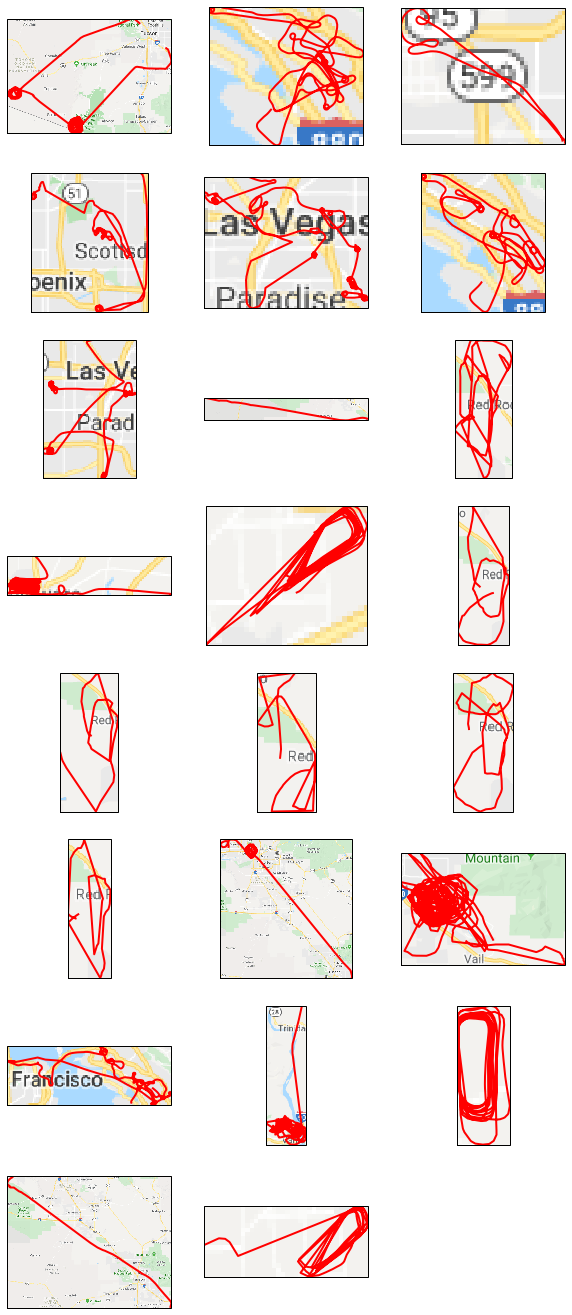

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt
import math

# Initialize our Google Maps tiles
actual_tiler = cimgt.GoogleTiles()
imagery = CachedTiler(actual_tiler)

# 3 per row, calculate number of rows
num_cols = 3
num_rows = math.ceil(len(flights) / num_cols)

# Make a 15x15 graphic
plt.figure(figsize=(10, num_rows * 3), facecolor='white')

for i, (name, flight) in enumerate(flights):
    ax = plt.subplot(num_rows, num_cols, i+1, projection=imagery.crs)

    # Set the boundaries around the map
    ax.set_extent([ 
        flight.longitude.max(), flight.longitude.min(),
        flight.latitude.min(), flight.latitude.max()
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)

    # Draw the path of the fligt
    track = sgeom.LineString(zip(flight.longitude, flight.latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)